## 9.1 LC-3 TRAP Routines
### 9.1.1 Introduction 
In order to have the program successfully obtain input from the keyboard, it was necessary for the programmer (in Chapter 8) to know several things:
1. The hardware data registers for both the keyboard and the monitor: the monitor so a prompt could be displayed, and the keyboard so the program would know where to look for the input character.
2. The hardware status registers for both the keyboard and the monitor: the monitor so the program would know when it was OK to display the next character in the input prompt, and the keyboard so the program would know when someone had struck a key.
3. The asynchronous nature of keyboard input relative to the executing program.

This is beyond the knowledge of most application programmers

There is another problem with allowing user programs to perform I/O activity by directly accessing KBDR and KBSR. 
- I/O activity involves the use of device registers that are shared by many programs.
- This means that if a user programmer were allowed to access the hardware registers, and he/she messed up, it could create havoc for other user programs.

Thus, it is ill-advised to give user programmers access to these registers. We say the hardware registers are **privileged** and accessible only to programs that have the proper degree of **privilege**. 

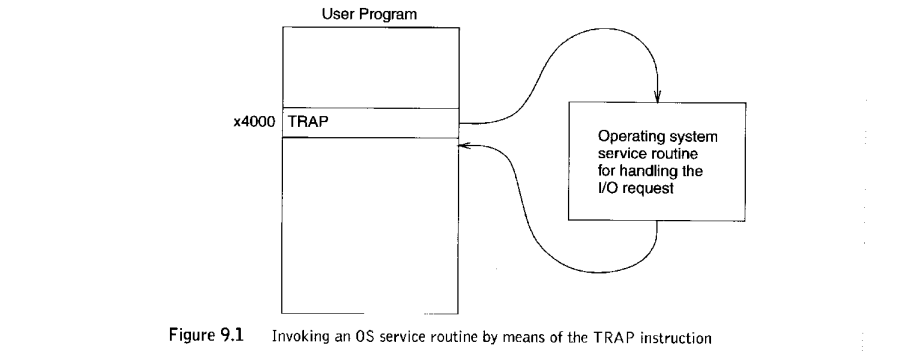

there are resources that are not accessible to the user program, and access to those resources is controlled by endowing some programs with sufficient privilege and other programs without

**The simpler solution as well as the safer solution to the problem of user programs requiring I/O involves the TRAP instruction and the operating system. The operating system does have the proper degree of privilege.**

TRAP instruction - for certain tasks, a user program could get the operating system to do the job for it by invoking the TRAP instruction
- That way, the user programmer does not have to know the gory details previously mentioned, and other user programs are protected from the consequences of inept user programmers.

**Figure 9.1** shows a user program that, upon reaching location `x4000`, needs an I/O task performed. 
- The user program requests the operating system to perform the task on behalf of the user program.
- The operating system takes control of the computer, handles the request specified by the **TRAP** instruction, and then returns control to the user program, at location `x4001`.
- We often refer to the request made by the user program as a **service call** or a **system call**.

### 9.1.2 The TRAP Mechanism 
The TRAP mechanism involves several elements, as follows: 
1. A set of service routines executed on behalf of user programs by the operating system.
- These are part of the operating system and start at arbitrary addresses in memory.
- The LC-3 was designed so that up to 256 service routines can be specified.

2. A table of the starting addresses of these 256 service routines.
- This table is stored in memory locations xOOOO to xOOFF.
- The table is referred to by various names by various companies.
- One company calls this table the **System Control Block**. Another company calls it the **Trap Vector Table**.

**Figure 9.2** provides a snapshot of the Trap Vector Table of the LC-3, with specific starting addresses highlighted.

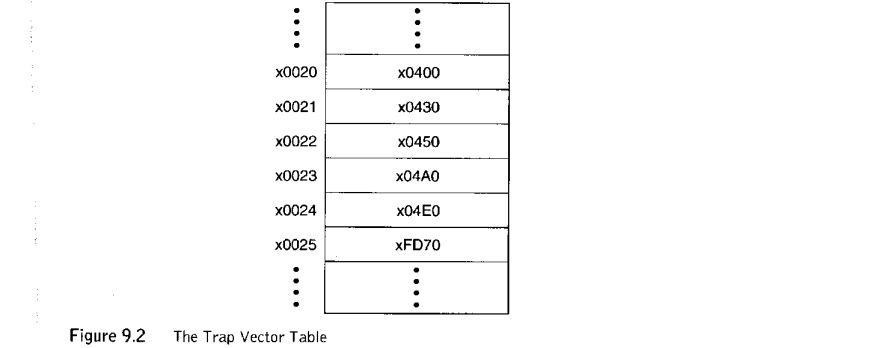

Among the starting addresses are the
one for the character output service routine (location x0430), which is
contained in location x0021, the one for the keyboard input service routine
(location x04A0), contained in location x0023, and the one for the machine
halt service routine (location xFD70), contained in location x0025. 

3. The TRAP instruction.
- When a user program wishes to have the operating system execute a specific service routine on behalf of the user program, and then return control to the user program, the user program uses the TRAP instruction.

4. A linkage back to the user program.
- The service routine must have a mechanism for returning control to the user program.

### 9.1.3 The TRAP Instruction 
The TRAP instruction causes the service routine to execute by doing two things:
- It changes the PC to the starting address of the relevant service routine on the basis of its trap vector.
- It provides a way to get back to the program that initiated the TRAP instruction. The "way back" is referred to as a linkage.

The TRAP instruction is specified as follows. The TRAP instruction is made up of two parts: the TRAP opcode 1111 and the trap vector (bits [7:0]). Bits [11:8] must be zero. The trap vector identifies the service routine the user program wants the operating system to perform. In the following example, the trap vector is x23. 

### 9.1.4 The Complete Mechanism 
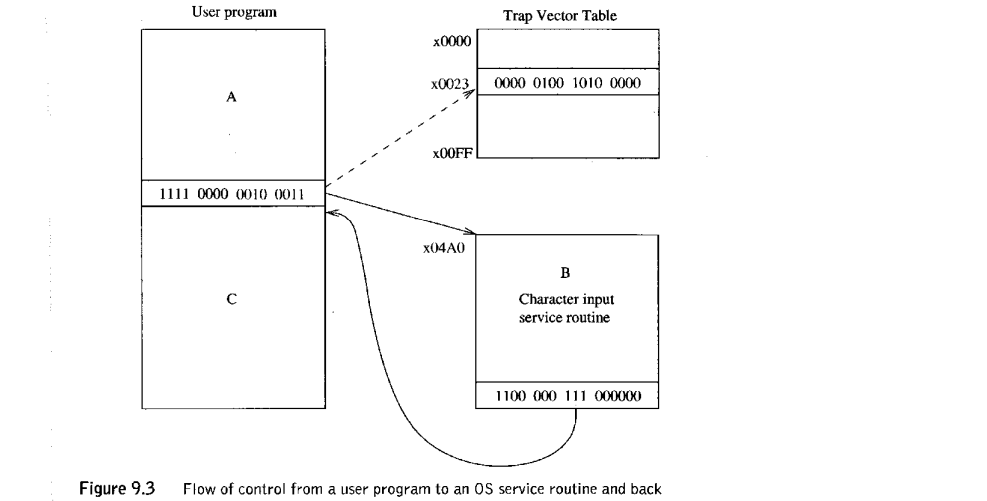

Figure 9.3 shows the LC-3 using the TRAP instruction and the JMP instruction to implement the example of Figure 9.1. The flow of control goes from (A) within a user program that needs a character input from the keyboard, to (B) the operating system service routine that performs that task on behalf of the user program, back to the user program (C) that presumably uses the information contained in the input character. 

Recall that the computer continually executes its instruction cycle (FETCH, DECODE, etc.). As you know, the way to change the flow of control is to change the contents of the PC during the EXECUTE phase of the current instruction. In that way, the next FETCH will be at a redirected address. 

### 9.1.5 TRAP Routines for Handling I/O 
With the constructs just provided, the input routine described in Figure 8.5 can
be slightly modified to be the input service routine shown in Figure 9.4. Two
changes are needed: (1) We add the appropriate .ORIG and .END pseudo-ops.
.ORIG specifies the starting address of the input service routine—the address
found at location x0023 in the Trap Vector Table. And (2) we terminate the input
service routine with the JMP R7 instruction (mnemonically, RET) rather than the
BR NEXT_TASK, as is done on line 20 in Figure 8.5. 

### 9.1.6 TRAP Routine for Halting the Computer 
Recall from Section 4.5 that the RUN latch is ANDed with the crystal oscillator to produce the clock that controls the operation of the computer.
- We noted that if that 1-bit latch was cleared, the output of the AND gate would be 0, stopping the clock.

Years ago, most ISAs had a HALT instruction for stopping the clock. Given how infrequently that instruction is executed, it seems wasteful to devote an opcode to it.

In many modern computers, the RUN latch is cleared by a TRAP routine

### 9.1.7 Saving and Restoring Registers 
One item we have mentioned in passing that we should emphasize more explicitly is the need to save the value in a register
- if the value will be destroyed by some subsequent action
- if we will need to use it after that subsequent action

We save a register value by storing it in memory; we restore it by loading it back into the register.
-  ST instruction stores R1
-  LD instruction that restores R1 to its original value before the service routine was called

The save/restore problem can be handled either by the initiating program before the TRAP occurs or by the called program (for example, the service routine) after the TRAP instruction executes

We use the term **caller-save** if the calling program handles the problem.
We use the term **callee-save** if the called program handles the problem. 

## 9.2 Subroutines 
We have just seen how programmers' productivity can be enhanced if they do not have to learn details of the I/O hardware, but can rely instead on the operating system to supply the program fragments needed to perform those tasks.

We also mentioned in passing that it is kind of nice to have the operating system access these device registers so we do not have to be at the mercy of some other user programmer.

We have seen that a request for a service routine is invoked in the user program by the `TRAP` instruction and handled by the operating system. Return to the initiating program is obtained via the `JMP R7` instruction.

It is almost always the case that collections of such fragments are available to user programmers to free them from having to write their own. These collections are referred to as **libraries**. 

Such program fragments are called **subroutines**, or alternatively, **procedures**, or in C terminology, **functions**. The mechanism for using them is referred to as a **Call/Return mechanism**. 

### 9.2.1 The Call/Return Mechanism 
The Call/Return mechanism allows us to execute this one 3-instruction sequence multiple times while requiring us to include it as a subroutine in our program only once. 

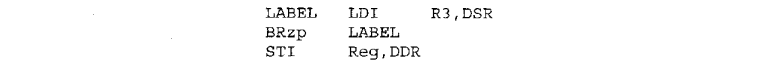

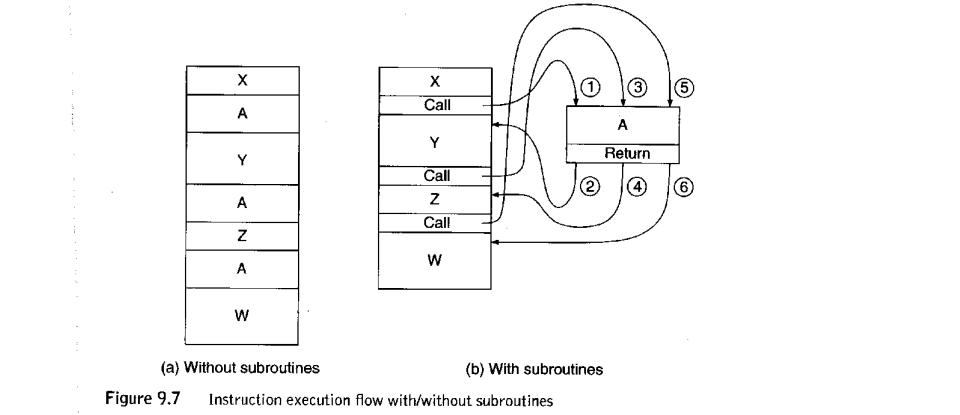

The call mechanism computes the starting address of the subroutine, loads it into the PC, and saves the return address for getting back to the next instruction in the calling program. The return mechanism loads the PC with the return address. Figure 9.7 shows the instruction execution flow for a program with and without subroutines.

The Call/Return mechanism acts very much like the TRAP instruction in that it redirects control to a program fragment while saving the linkage back to the calling program.

The last instruction in the program fragment, whether the
fragment is a trap service routine or a subroutine, is the JMP R7 instruction, which
loads the PC with the contents of R7, thereby returning control to the instruction
following the calling instruction. 

### 9.2.2 The JSR(R) Instruction
The LC-3 specifies one opcode for calling subroutines, 0100.

The instruction does two things. It saves the return address in R7 and it computes the starting address of the subroutine and loads it into the PC

The return address is the incremented PC, which points to the instruction following the JSR or JSRR instruction in the calling program. 

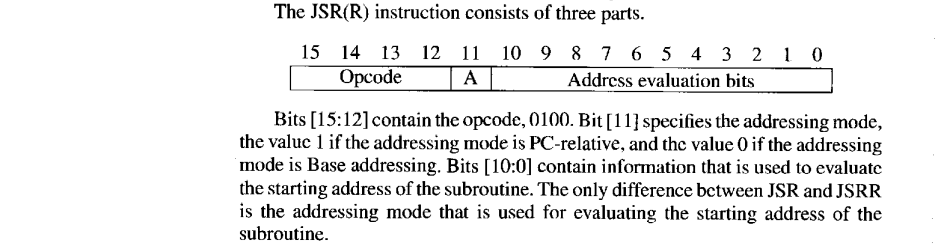


### 9.2.4 PUTS: Writing a Character String to the Monitor 
A sequence of characters is often referred to
as a string of characters or a character string. This fragment is also present in
Figure 9.6, with the result that Halting the machine is written to the monitor.
In fact, it is so often the case that a user program needs to write a string of
characters to the monitor that this function is given its own trap vector in the LC-3
operating system. Thus, if a user program requires a character string to be written
to the monitor, it need only provide (in RO) the starting address of the character
string, and then invoke TRAP x22. In LC-3 assembly language this TRAP is
called PITTS.

Thus, PUTS (or TRAP x22) causes control to be passed to the operating system, and the procedure is executed. 

### 9.2.5 Library Routines 
We noted early in this section that there are many uses for the Call/Return mechanism, among them the ability of a user program to call library subroutines that are usually delivered as part of the computer system

Two things are worth noting:
- Thing 1—The programmer no longer has to worry about how to compute the square root function. The library routine does that for us.
- Thing 2—The pseudo-op .EXTERNAL. We already saw in Section 7.4.2 that this pseudo-op tells the assembler that the label (SQRT), which is needed to assemble the .FILL pseudo-op in line 19, will be supplied by some other program fragment (i.e., module) and will be combined with this program fragment (i.e., module) when the executable image is produced. The executable image is the binary module that actually executes. The executable image is produced at link time. 

This notion of combining multiple modules at link time to produce an executable image is the normal case. 

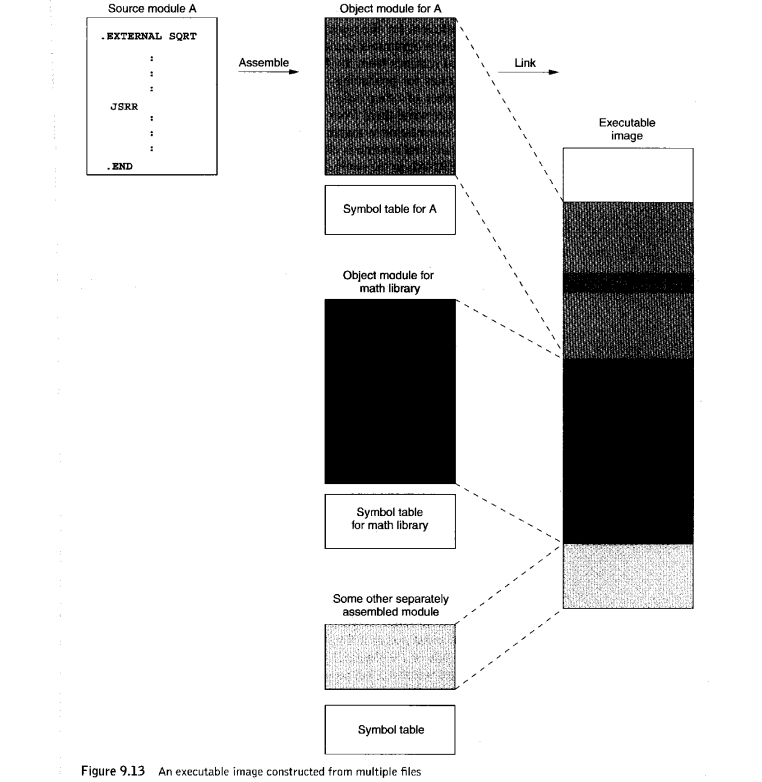

Most application software requires library routines from various libraries. 

There are other routines for a number of other tasks where it would make no sense at all to have the programmer write them from scratch. 

It is much easier to require only:
1. appropriate documentation so that the interface between the library routine and the program that calls that routine is clear
2. the use of the proper pseudoops such as .EXTERNAL in the source program. The linker can then produce an executable image at link time from the separately assembled modules. 